# Cython

## 1. Compiling & Running Cython

### 1.1 Distutils
This is the standard way, using a setup.py file with:

In [8]:
from distutils.core import setup
from Cython.Build import cythonize

Then you compile using:

```python setup.py build_ext```

```python setup.py build_ext --compiler=msvc``` if Windows and Visual Studio C++

In order to automatically include it with pip, do:

```pip install --upgrade setup.py ```

If anything went wrong, you can always delete it:

```pip uninstall PACKAGENAME```

In [26]:
import fib
fib.fib(50)
#Int size condiitons the result!

-298632863

### 1.2 IPython magic

In [3]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [31]:
%%cython -n fib2 -a
def fib_magic(long n):
    cdef long i
    cdef double a=0.0, b=1.0
    for i in range(n):
        a, b = a+b, a
    return a

In [32]:
fib_magic

<function fib2.fib_magic>

## 2. Cython in Depth

### 2.1 Static type declaration with cdef

In [46]:
%%cython 
def myFun(a, b):
    cdef int i=1, k, l
    cdef:
        float p = 3.3
        long int j = 2
    return a*i+b*j+p

In [47]:
myFun(1,2)

8.299999952316284

In [49]:
%%cython 
def cdefExamples():
    # Pointers
    cdef int *p     # Single dereference
    cdef void **buf # Double dereference, e.g.: char* a[] == char** a
                    #  Pointer to pointer, pointer to array,
                    #  array of pointers, array of arrays
    
    # Stack allocated C arrays
    cdef int arr[10]
    cdef double points[20][30]
    # typedef - new stuff
    cdef size_t len
    # Structs and Unions
    #cdef tm time_struct
    #cdef int_short_union_t hi_lo_bytes
    # Function pointers
    cdef void (*f)(int, double)
    return None

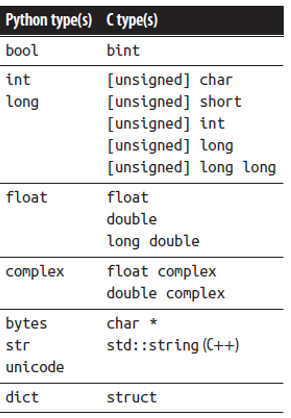


### 2.2 C Pointers in Cython
Defining C pointers is like in C, but accessing them is done like an array

In [14]:
%%cython
cdef int *p_int
cdef int a=123
p_int=&a
p_int[0]=3
print(a)

3


Accessing structs is done using dot instead of arrow

In [25]:
%%cython 
cdef struct st_t:
    int a

cdef st_t ss = st_t(a=2)
cdef st_t *p_st = &ss
cdef int a_doubled = p_st.a + p_st.a
print(a_doubled)

4


### 2.3 Functions in Cython
There are three ways to define functions:
1. ```def``` statement, allowing both python objects and c objects to be called
2. ```cdef``` using a c-only version that will not be called outside the Python code. Requires python wrappers. Can be called by both inside Python and C
3. ```cpdef``` hybrid between the two. Can be called by outside Python, reuqires arguments and return types to be compatible with C and Python. All Python objects are included, but void, C pointers or C arrays are not possible. Check table.

In [26]:
# Pure python
def py_fact(n):
    if n<=1:
        return 1
    return n * py_fact(n-1)

In [31]:
%%cython
# Statically typed variable, but still python function and objects
def typed_fact(long n):
    if n<=1:
        return 1
    return n * typed_fact(n-1)

In [39]:
%%cython
# C function in Cython. iIt could use inline
cdef long c_fact(long n):
    if n<=1:
        return 1
    return n * c_fact(n-1)
def wrap_c_fact(n):
    return c_fact(n)

In [56]:
%%cython
# Callable C function in Python
# INLINE suggests the compiler to replace the function calls by the code
cpdef inline long cp_fact(long n):
    if n<=1:
        return 1
    return n * cp_fact(n-1)

In [29]:
%timeit py_fact(20)

2.56 µs ± 29.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [33]:
%timeit typed_fact(20)

1.05 µs ± 15.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [48]:
%timeit wrap_c_fact(20)

91.5 ns ± 0.657 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [47]:
%timeit cp_fact(20)

89.3 ns ± 0.866 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


#### 2.3.1 Exceptions

In [50]:
%%cython
# Question mark is used if value could be generated without Exception.
#   Value must be in range of type
# except* would always check for exception, but has overhead.
cpdef double divide_ints(double i, double j) except? -1:
    return i / j

In [51]:
divide_ints(1, 0)

ZeroDivisionError: float division

In [53]:
py_fact? # Check info on that object

### 2.4 Type Casting
Insteado of the C parentehses, Cython uses <> for Explicit casting.

In [ ]:
%%cython
a = 3
cdef list cast_list = <list>a # If we are certain of the casting
cdef list cast_list2 = <list?>a # If we are certain of the casting

### 2.5 Structs, Unions and Enums 

#### 2.5.1 Declaration

In [ ]:
%%cython
# Seamless creation
cdef struct mycpx:
    float real
    float imag
cdef union uu:
    int a
    short b, c    
cdef enum PRIMARIES:
    RED = 1
    YELLOW = 3
    BLUE = 5
    
# Creating also a new type alias
ctypedef struct mycpx:
    float real
    float imag
ctypedef union uu:
    int a
    short b, c
ctypedef enum SECONDARIES:
    ORANGE, GREEN, PURPLE
    
# Anonymous stucts and unions are not supported, but anonymous enums are:
cdef enum:
    GLOBAL_SEED = 37

#### 2.5.2 Initialization

In [ ]:
%%cython
# Struct Literals
cdef mycpx a = mycpx(3.1415, -1.0)
cdef mycpx b = mycpx(real=2.718, imag=1.618034)
# By inidvidual names
cdef mycpx zz
zz.real = 3.1415
zz.imag = -1.0
# Form a Python dictionary (more Python overhead)
cdef mycpx zz = {'real': 3.1415, 'imag': -1.0}

Nested Structs/unions are not supported. You need to unnest. (page 58 manual)

### 2.6 Type Aliasing with ctypedef
Used to generate new types based on current types.

In [ ]:
%%cython
ctypedef double real
ctypedef long integral

def displacement(real d0, real v0, real a, real t):
    """Calculates displacement under constant acceleration."""
    cdef real d = d0 + (v0 * t) + (0.5 * a * t**2)
    return d

#### 2.6.1 Fused Types

They allow several types on one, generating replicas of functions for each type. `integral`, `floating` and `numeric`.

In [ ]:
%%cython
from cython cimport integral
cpdef integral integral_max(integral a, integral b):
    return a if a >= b else b

In [59]:
%%cython
# we can also create our own fused type
cimport cython
ctypedef fused integral_or_floating:
    cython.short
    cython.int
    cython.long
    cython.float
    cython.double